<a href="https://colab.research.google.com/github/Amanparijoshi/cgm-glucose-forecasting-lstm-gru/blob/main/Allsubjects_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Data prepared: X_train=(228, 20, 1), X_test=(58, 20, 1)

🚀 Training LSTM...
Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0908 - val_loss: 0.0382
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0362 - val_loss: 0.0366
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0278 - val_loss: 0.0382
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0282 - val_loss: 0.0364
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0271 - val_loss: 0.0385
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0227 - val_loss: 0.0370
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0279 - val_loss: 0.0379
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0271 - val_loss: 0.0375
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0259 - val_loss: 0.0379
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0257 - val_loss: 0.0371
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 

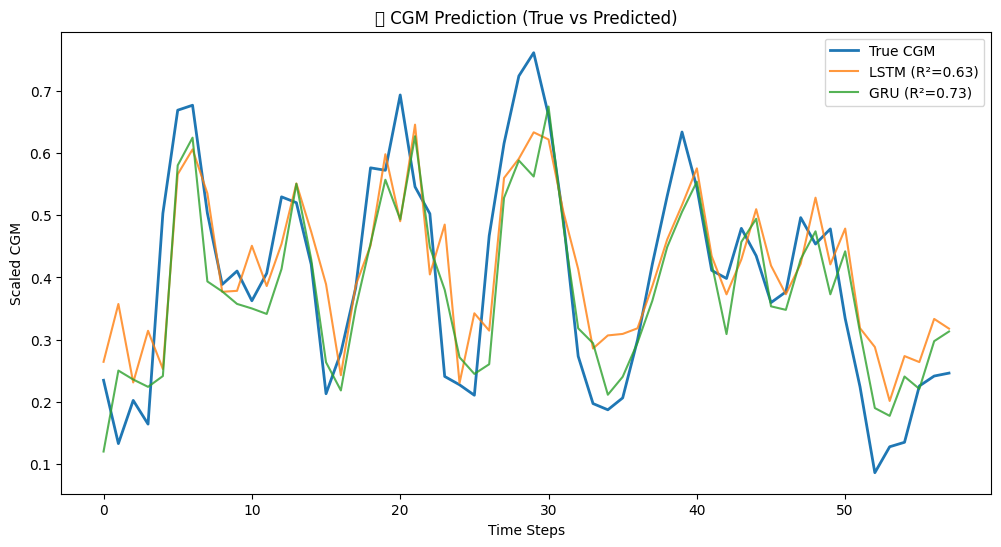


✅ Results saved successfully at: /content/drive/MyDrive/diabetes/results/CGM_LSTM_GRU_results.csv
  Model        R2      RMSE       MAE
0  LSTM  0.629829  0.104353  0.084239
1   GRU  0.725988  0.089782  0.070582


In [ ]:
# ==============================
# 🔹 CGM-Only LSTM & GRU (without extra food related data)
# ==============================

!pip install tensorflow scikit-learn matplotlib pandas --quiet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# ==============================
# 1️⃣ Load and Prepare Data
# ==============================
file_path = "/content/drive/MyDrive/diabetes/Subject 1_3hr.csv"  # ✅ Update if needed
data = pd.read_csv(file_path)

if 'CGM' not in data.columns:
    raise ValueError("❌ 'CGM' column not found in dataset!")

# Smooth the CGM signal (rolling mean)
data['CGM_smooth'] = data['CGM'].rolling(window=3, center=True).mean()
data = data.dropna(subset=['CGM_smooth']).reset_index(drop=True)

# Normalize
scaler = MinMaxScaler()
scaled_cgm = scaler.fit_transform(data[['CGM_smooth']])

# ==============================
# 2️⃣ Create Sequence Data
# ==============================
def create_sequences(dataset, window=20):
    X, y = [], []
    for i in range(len(dataset) - window):
        X.append(dataset[i:i + window])
        y.append(dataset[i + window])
    return np.array(X), np.array(y)

window_size = 20
X, y = create_sequences(scaled_cgm, window_size)

# Split data sequentially (no shuffle)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"✅ Data prepared: X_train={X_train.shape}, X_test={X_test.shape}")

# ==============================
# 3️⃣ Define Models
# ==============================

# LSTM
lstm_model = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    LSTM(64, activation='tanh', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(0.001), loss='mse')

# GRU
gru_model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(window_size, 1)),
    Dropout(0.2),
    GRU(64, activation='tanh', return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])
gru_model.compile(optimizer=Adam(0.001), loss='mse')

# ==============================
# 4️⃣ Train (100 Epochs)
# ==============================
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\n🚀 Training LSTM...")
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=100, batch_size=8, validation_split=0.2,
    verbose=1, callbacks=[es]
)

print("\n🚀 Training GRU...")
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=100, batch_size=8, validation_split=0.2,
    verbose=1, callbacks=[es]
)

# ==============================
# 5️⃣ Evaluate Models
# ==============================
def evaluate_model(model, X_test, y_test, name):
    preds = model.predict(X_test).flatten()
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    print(f"\n📊 {name} Results:")
    print(f"R²   = {r2:.4f}")
    print(f"RMSE = {rmse:.6f}")
    print(f"MAE  = {mae:.6f}")
    return {"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae}

lstm_results = evaluate_model(lstm_model, X_test, y_test, "LSTM")
gru_results = evaluate_model(gru_model, X_test, y_test, "GRU")

# ==============================
# 6️⃣ Plot Predictions
# ==============================
plt.figure(figsize=(12,6))
plt.plot(y_test, label="True CGM", linewidth=2)
plt.plot(lstm_model.predict(X_test), label=f"LSTM (R²={lstm_results['R2']:.2f})", alpha=0.8)
plt.plot(gru_model.predict(X_test), label=f"GRU (R²={gru_results['R2']:.2f})", alpha=0.8)
plt.title("📈 CGM Prediction (True vs Predicted)")
plt.xlabel("Time Steps")
plt.ylabel("Scaled CGM")
plt.legend()
plt.show()

# ==============================
# 7️⃣ Save Results Only
# ==============================
save_dir = "/content/drive/MyDrive/diabetes/results/"
os.makedirs(save_dir, exist_ok=True)

results_df = pd.DataFrame([lstm_results, gru_results])
results_path = os.path.join(save_dir, "CGM_LSTM_GRU_results.csv")
results_df.to_csv(results_path, index=False)

print("\n✅ Results saved successfully at:", results_path)
print(results_df)


In [ ]:
# ==============================
# 🔹 Traditional ML Models for CGM-Only Data(without extra food related data)
# ==============================

!pip install lightgbm scikit-learn pandas --quiet

import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb

# ==============================
# 1️⃣ Reuse Preprocessed Data
# ==============================
# Make sure you’ve run the previous LSTM-GRU section first.
# It already defines: X_train, X_test, y_train, y_test

print(f"✅ Using existing data shapes: X_train={X_train.shape}, X_test={X_test.shape}")

# Flatten sequence data for traditional models
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# ==============================
# 2️⃣ Define Traditional Models
# ==============================
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=200, random_state=42),
    "HistGB": HistGradientBoostingRegressor(random_state=42),
    "LightGBM": lgb.LGBMRegressor(n_estimators=200, random_state=42)
}

results = []

# ==============================
# 3️⃣ Train and Evaluate
# ==============================
for name, model in models.items():
    print(f"\n🚀 Training {name}...")
    model.fit(X_train_flat, y_train)
    preds = model.predict(X_test_flat)
    r2 = r2_score(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    results.append({"Model": name, "R2": r2, "RMSE": rmse, "MAE": mae})
    print(f"{name}: R2={r2:.3f}, RMSE={rmse:.4f}, MAE={mae:.4f}")

# ==============================
# 4️⃣ Save Results to Same File
# ==============================
save_dir = "/content/drive/MyDrive/diabetes/results/"
os.makedirs(save_dir, exist_ok=True)

results_path = os.path.join(save_dir, "CGM_LSTM_GRU_results.csv")

# Append new results to the file created by the LSTM/GRU section
if os.path.exists(results_path):
    existing_results = pd.read_csv(results_path)
    final_results = pd.concat([existing_results, pd.DataFrame(results)], ignore_index=True)
else:
    final_results = pd.DataFrame(results)

final_results.to_csv(results_path, index=False)

print("\n✅ All Results Saved at:", results_path)
print(final_results)


✅ Using existing data shapes: X_train=(228, 20, 1), X_test=(58, 20, 1)

🚀 Training LinearRegression...
LinearRegression: R2=0.703, RMSE=0.0935, MAE=0.0735

🚀 Training RandomForest...
RandomForest: R2=0.647, RMSE=0.1019, MAE=0.0840

🚀 Training ExtraTrees...
ExtraTrees: R2=0.568, RMSE=0.1128, MAE=0.0906

🚀 Training HistGB...
HistGB: R2=0.623, RMSE=0.1053, MAE=0.0847

🚀 Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 228, number of used features: 20
[LightGBM] [Info] Start training from score 0.391680
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

In [ ]:
import numpy as np, tensorflow as tf
print("✅ NumPy:", np.__version__)
print("✅ TensorFlow:", tf.__version__)



✅ NumPy: 2.0.2
✅ TensorFlow: 2.19.0



✅ CGM Summary:
count    3733.000000
mean      141.834124
std        26.759122
min        64.000000
25%       122.812500
50%       139.143519
75%       158.812500
max       254.800000
Name: CGM, dtype: float64


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.2960, R²=0.9972

📊 Random Forest Meta Results: RMSE=1.4649, R²=0.9965


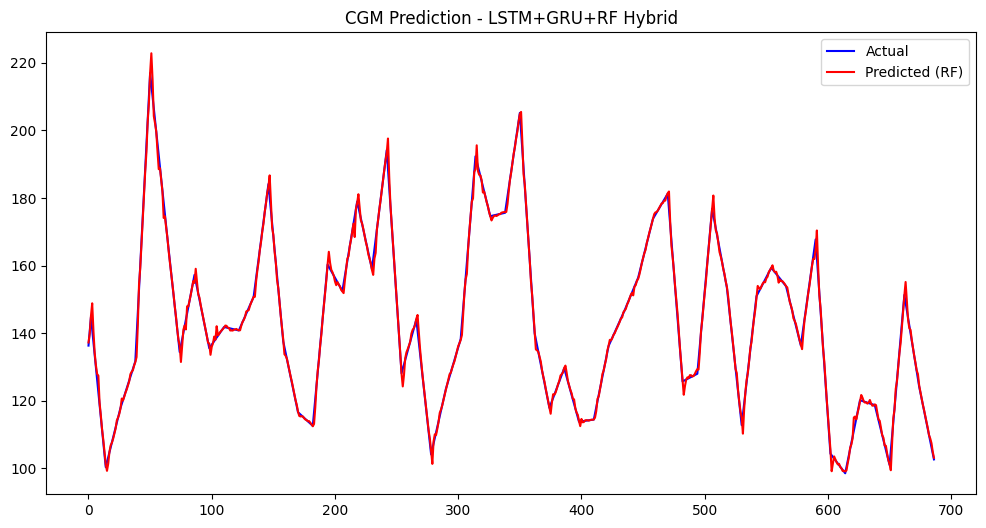

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 1_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()


Mounted at /content/drive


/tmp/ipython-input-1778433225.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    3733.000000
mean      155.779633
std        28.752892
min        90.083333
25%       135.097222
50%       151.000000
75%       169.092593
max       283.416667
Name: CGM, dtype: float64
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.4994, R²=0.9961

📊 Random Forest Meta Results: RMSE=1.8643, R²=0.9940


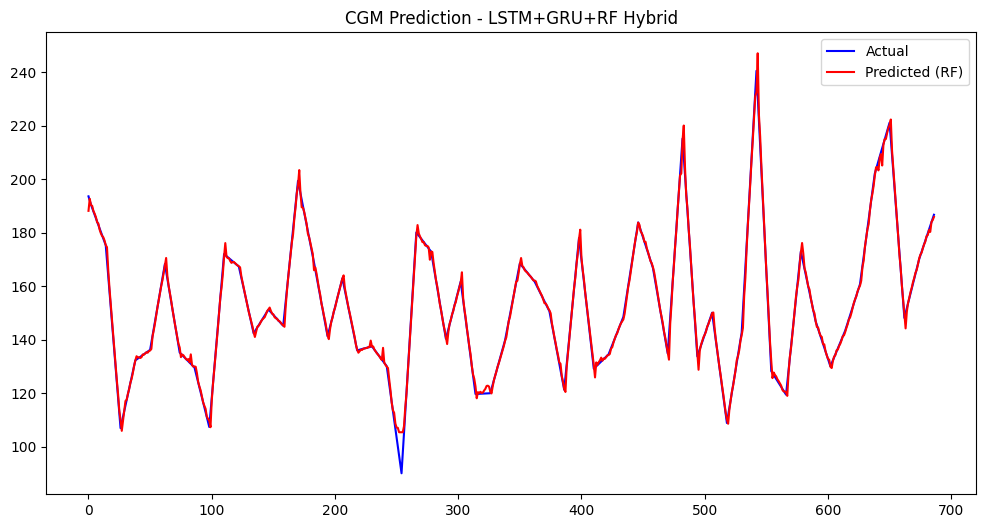

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from google.colab import drive
# ================================
# 💾 Mount Drive
# ================================
drive.mount('/content/drive')


# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 2_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-917372435.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    3733.000000
mean      138.829721
std        30.309229
min        70.166667
25%       117.073552
50%       133.314815
75%       153.863426
max       261.944444
Name: CGM, dtype: float64
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Linear Regression Meta Results: RMSE=1.5778, R²=0.9960

📊 Random Forest Meta Results: RMSE=1.5668, R²=0.9960


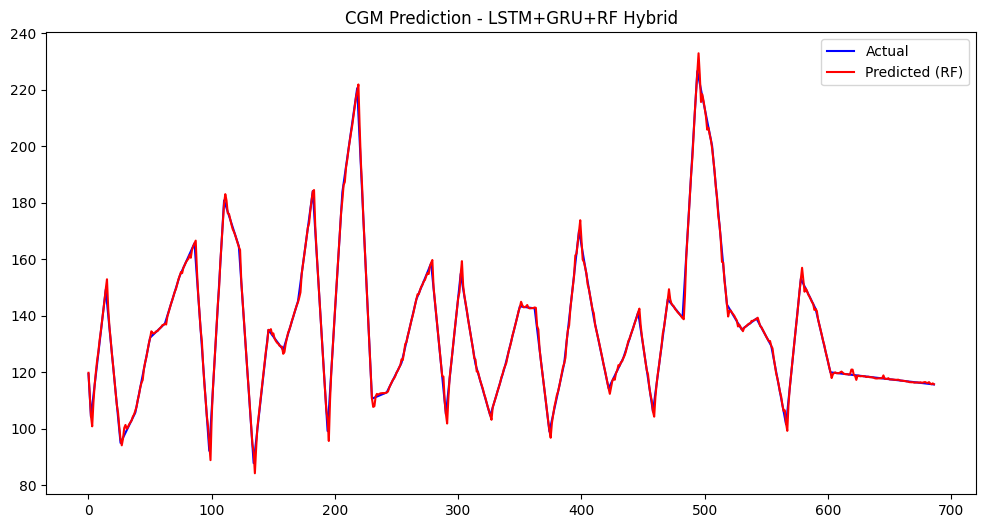

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 3_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-2978167357.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4297.000000
mean      171.209149
std        37.149120
min        91.305556
25%       144.958333
50%       166.898148
75%       191.152778
max       335.666667
Name: CGM, dtype: float64
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.6536, R²=0.9972

📊 Random Forest Meta Results: RMSE=1.7308, R²=0.9970


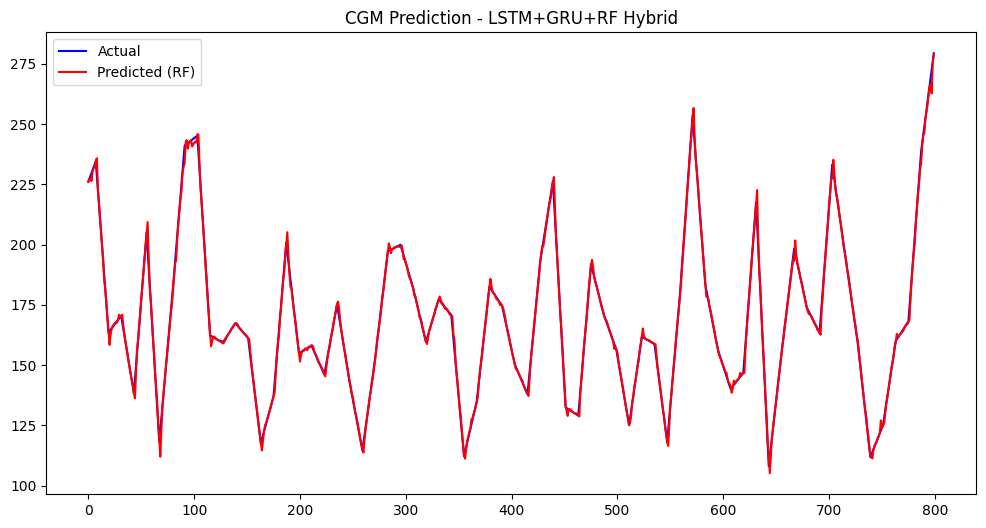

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 4_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-617478334.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4405.000000
mean      134.365839
std        28.500796
min        44.305556
25%       116.210648
50%       130.796296
75%       149.243056
max       252.611111
Name: CGM, dtype: float64
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Linear Regression Meta Results: RMSE=1.9082, R²=0.9950

📊 Random Forest Meta Results: RMSE=2.1635, R²=0.9935


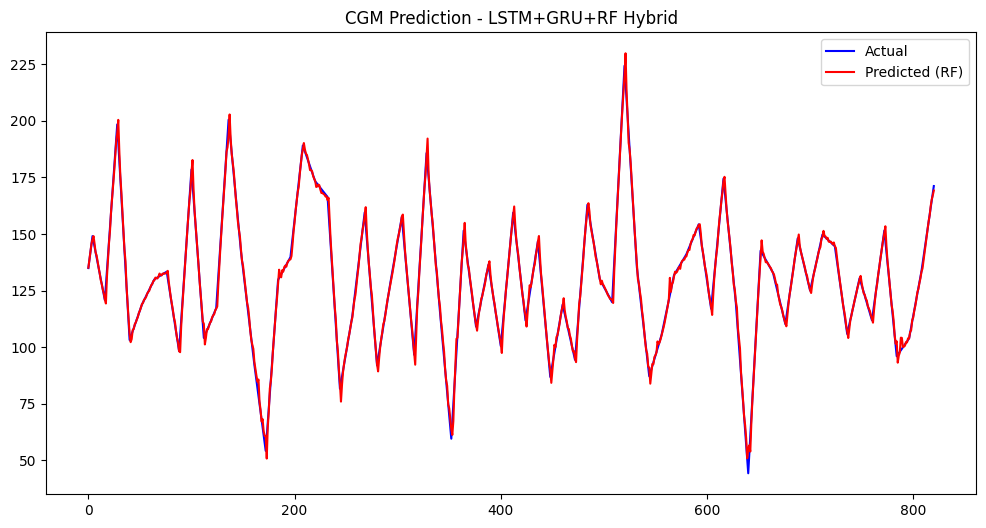

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 5_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-773185499.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4273.000000
mean      143.498727
std        21.764238
min        98.166667
25%       126.500000
50%       139.500000
75%       158.145833
max       220.583333
Name: CGM, dtype: float64
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

📊 Linear Regression Meta Results: RMSE=1.2249, R²=0.9973

📊 Random Forest Meta Results: RMSE=1.3857, R²=0.9965


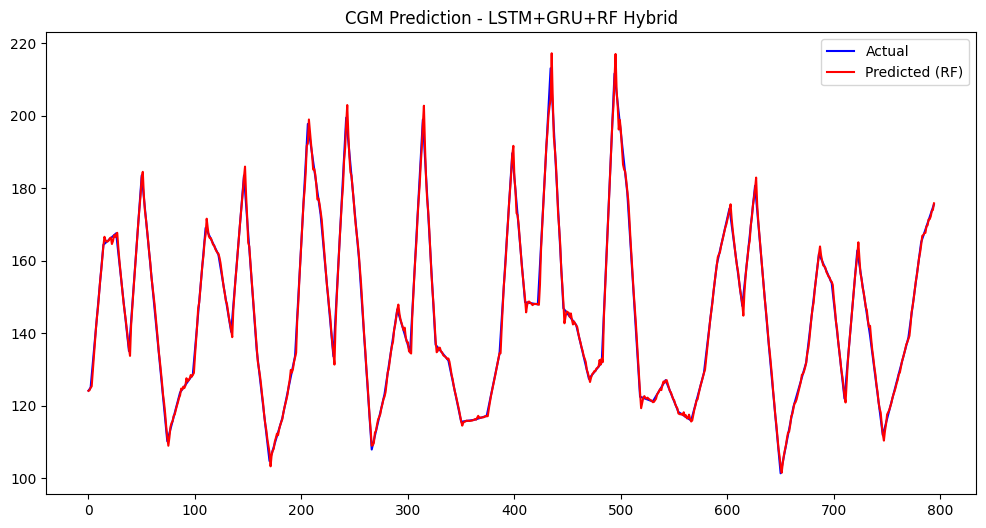

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 6_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-333777128.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4501.000000
mean      142.762518
std        23.642773
min        73.833333
25%       126.916667
50%       141.592593
75%       156.106481
max       268.545455
Name: CGM, dtype: float64
111/111 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.0599, R²=0.9973

📊 Random Forest Meta Results: RMSE=1.1807, R²=0.9966


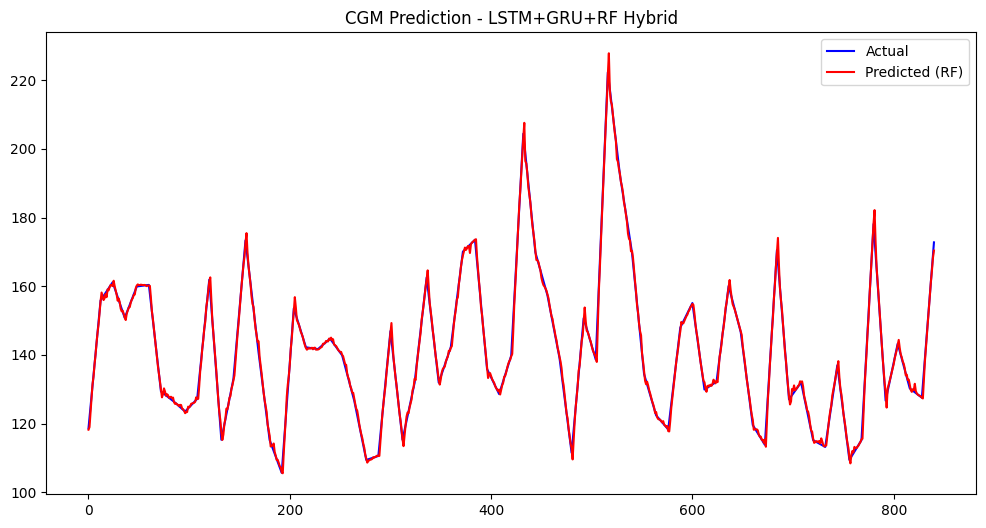

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 7_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-4250993395.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    2689.000000
mean      160.130462
std        34.135498
min        98.716667
25%       133.734722
50%       152.317222
75%       180.353704
max       286.097143
Name: CGM, dtype: float64
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

📊 Linear Regression Meta Results: RMSE=2.0183, R²=0.9973

📊 Random Forest Meta Results: RMSE=2.0850, R²=0.9971


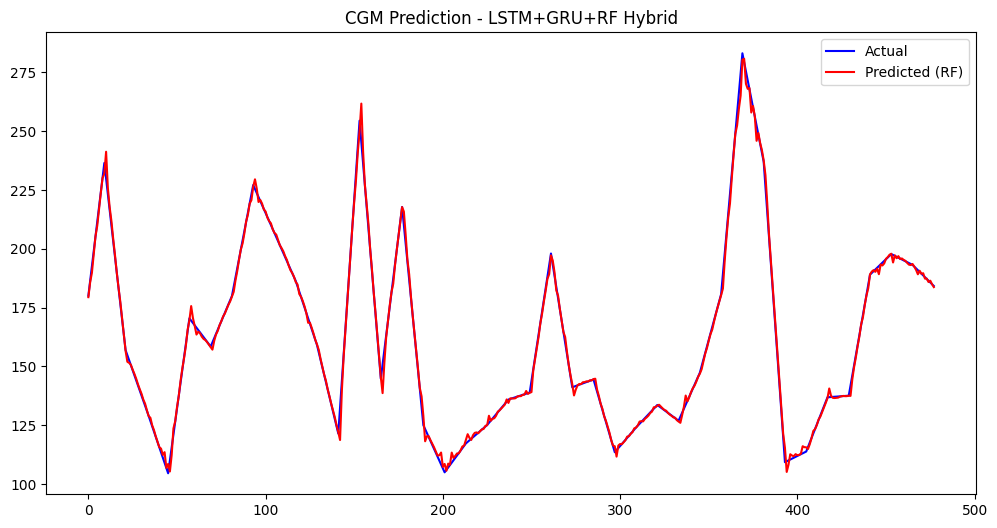

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 8_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-680417226.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    3733.000000
mean      191.595450
std        54.070238
min        72.972222
25%       151.157407
50%       187.805556
75%       228.916667
max       369.527778
Name: CGM, dtype: float64
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.9942, R²=0.9989

📊 Random Forest Meta Results: RMSE=2.3940, R²=0.9984


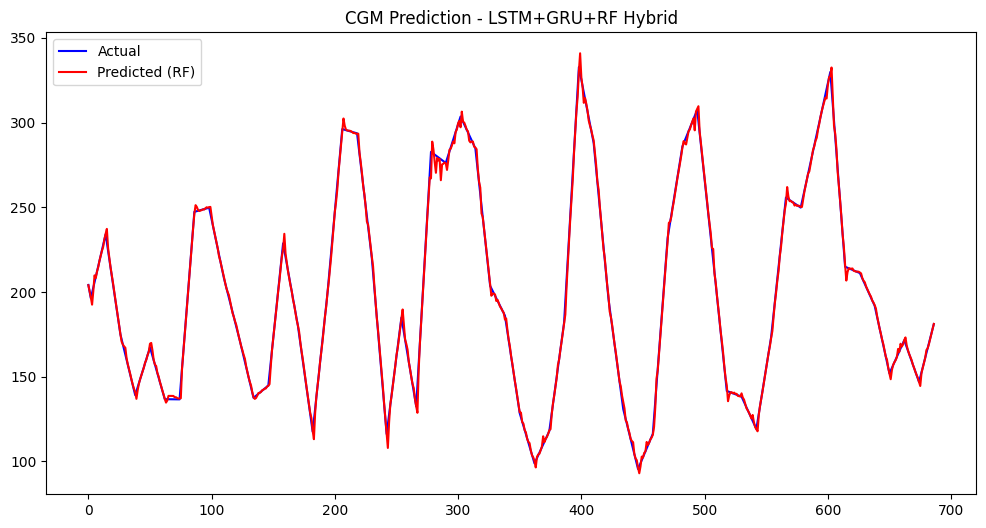

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 9_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-1695059417.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4021.000000
mean      155.635029
std        42.842657
min        82.361111
25%       122.430556
50%       149.013889
75%       181.828704
max       353.000000
Name: CGM, dtype: float64
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.5426, R²=0.9960

📊 Random Forest Meta Results: RMSE=1.5594, R²=0.9959


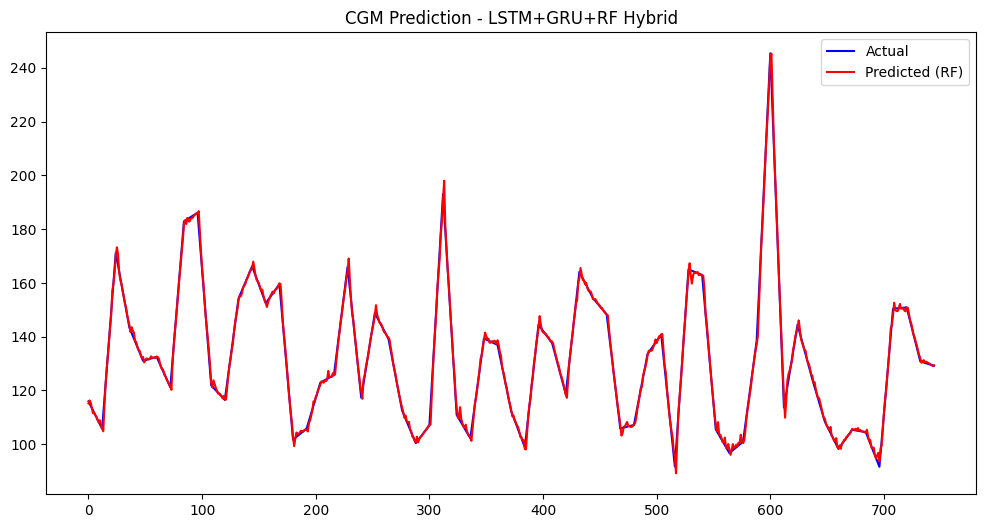

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 10_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-1961808583.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4309.000000
mean      166.204135
std        38.343538
min        78.944444
25%       138.965278
50%       160.520833
75%       186.972222
max       329.472222
Name: CGM, dtype: float64
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step

📊 Linear Regression Meta Results: RMSE=1.5716, R²=0.9970

📊 Random Forest Meta Results: RMSE=1.6891, R²=0.9965


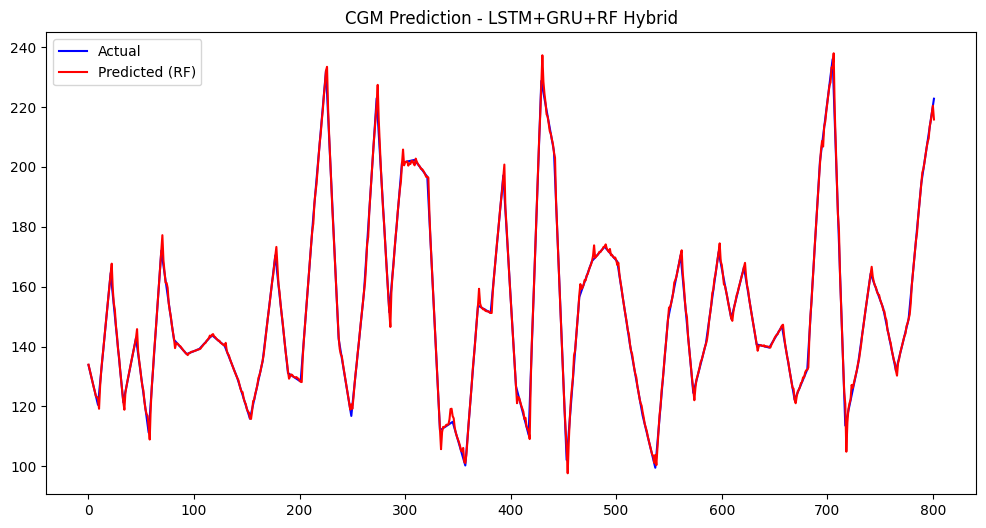

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 11_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-2740949149.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4213.000000
mean      135.502884
std        28.099318
min        75.583333
25%       115.541667
50%       131.648148
75%       150.736111
max       261.861111
Name: CGM, dtype: float64
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.4809, R²=0.9952

📊 Random Forest Meta Results: RMSE=1.6135, R²=0.9943


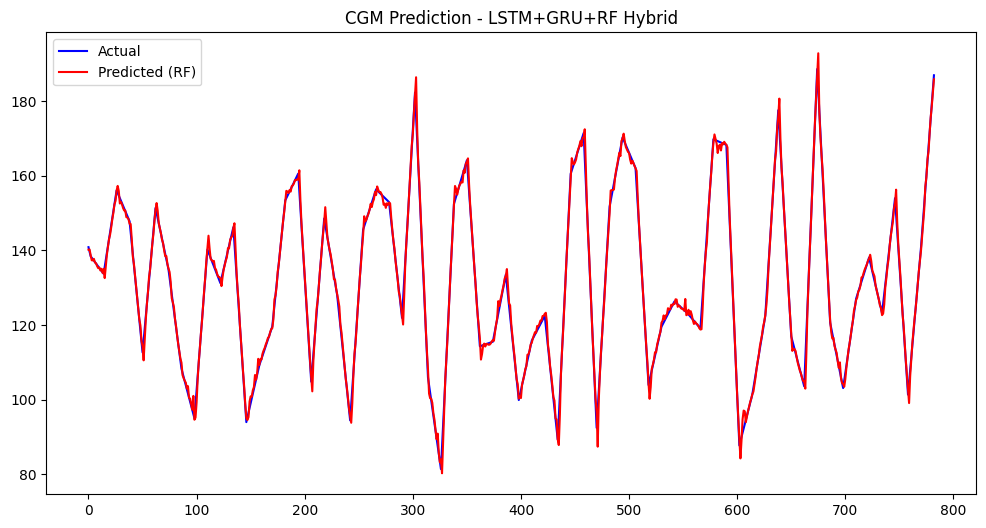

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 12_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-1255377960.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4309.000000
mean      134.695861
std        17.933164
min        83.277778
25%       121.717593
50%       134.740741
75%       146.564815
max       196.666667
Name: CGM, dtype: float64
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Linear Regression Meta Results: RMSE=0.8781, R²=0.9971

📊 Random Forest Meta Results: RMSE=0.9990, R²=0.9962


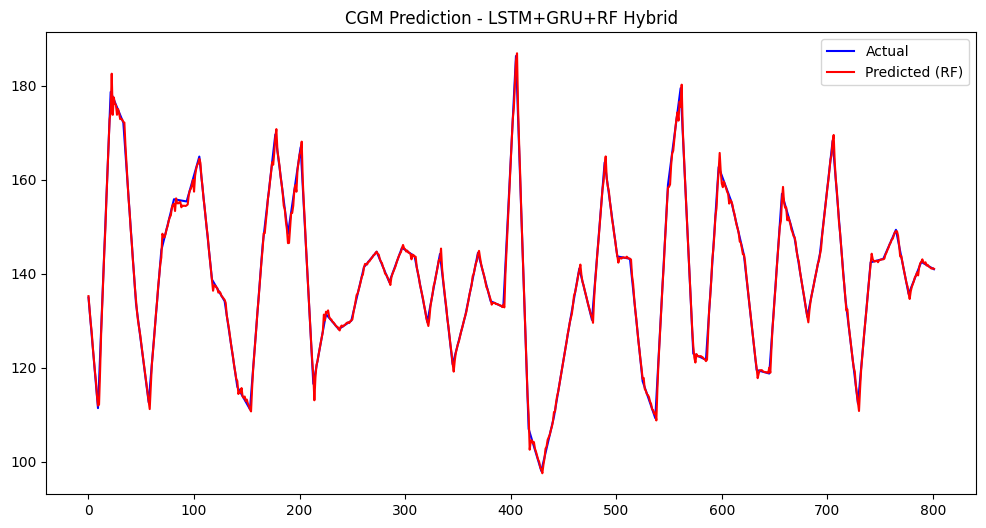

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 13_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-2435304257.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4309.000000
mean      108.223486
std        21.876576
min        40.000000
25%        92.250000
50%       106.000000
75%       123.000000
max       184.000000
Name: Readings (CGM / BGM), dtype: float64
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=1.8795, R²=0.9938

📊 Random Forest Meta Results: RMSE=2.0837, R²=0.9924


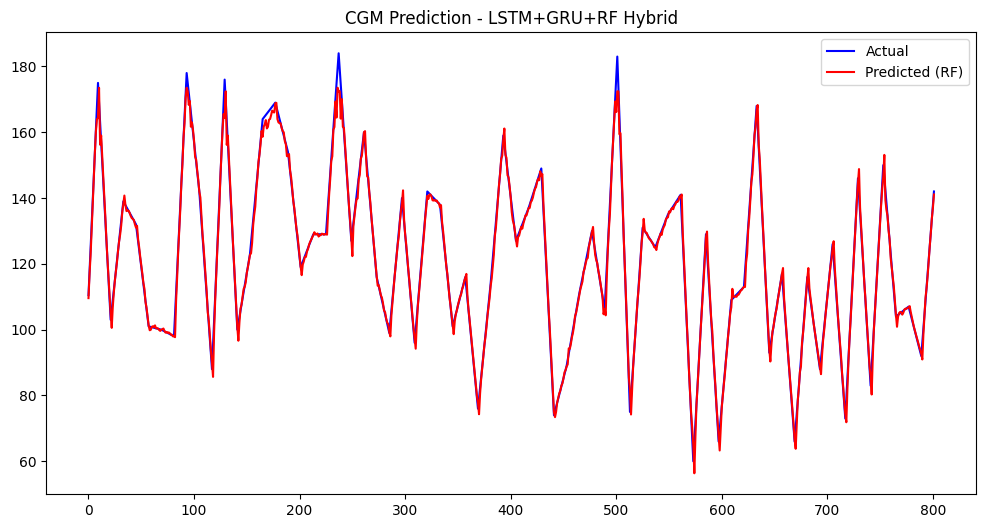

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 14_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-2518591251.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4693.000000
mean      136.128489
std        47.038393
min        40.000000
25%       106.583333
50%       127.500000
75%       155.250000
max       400.000000
Name: CGM, dtype: float64
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Linear Regression Meta Results: RMSE=2.2885, R²=0.9983

📊 Random Forest Meta Results: RMSE=2.7251, R²=0.9975


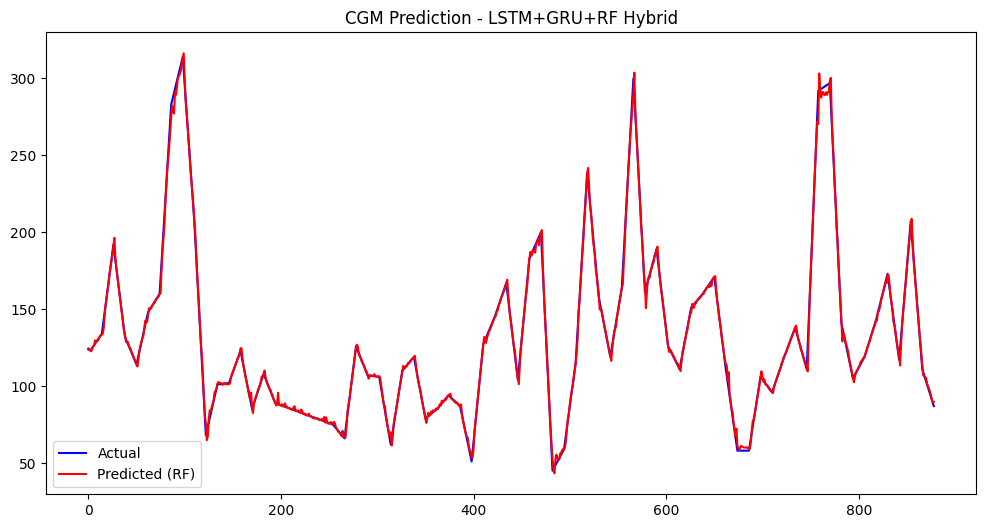

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 15_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 16_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-919155934.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4213.000000
mean      153.092808
std        41.535449
min        46.000000
25%       124.000000
50%       147.000000
75%       174.833333
max       390.000000
Name: CGM, dtype: float64
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

📊 Linear Regression Meta Results: RMSE=2.8977, R²=0.9957

📊 Random Forest Meta Results: RMSE=4.9498, R²=0.9873


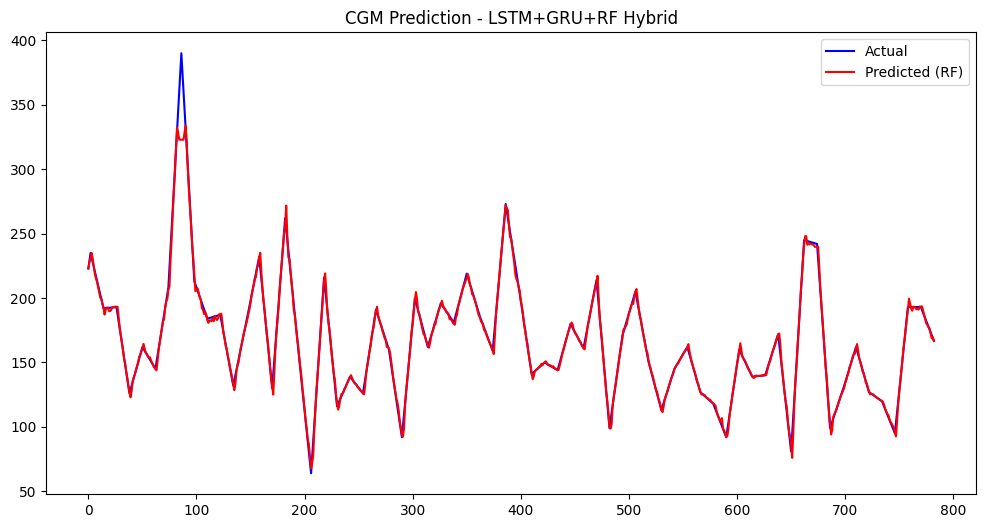

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 17_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-1186231309.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    3541.000000
mean      151.370940
std        41.393070
min        55.000000
25%       122.166667
50%       144.250000
75%       172.583333
max       334.000000
Name: CGM, dtype: float64
87/87 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Linear Regression Meta Results: RMSE=2.8393, R²=0.9964

📊 Random Forest Meta Results: RMSE=4.2896, R²=0.9918


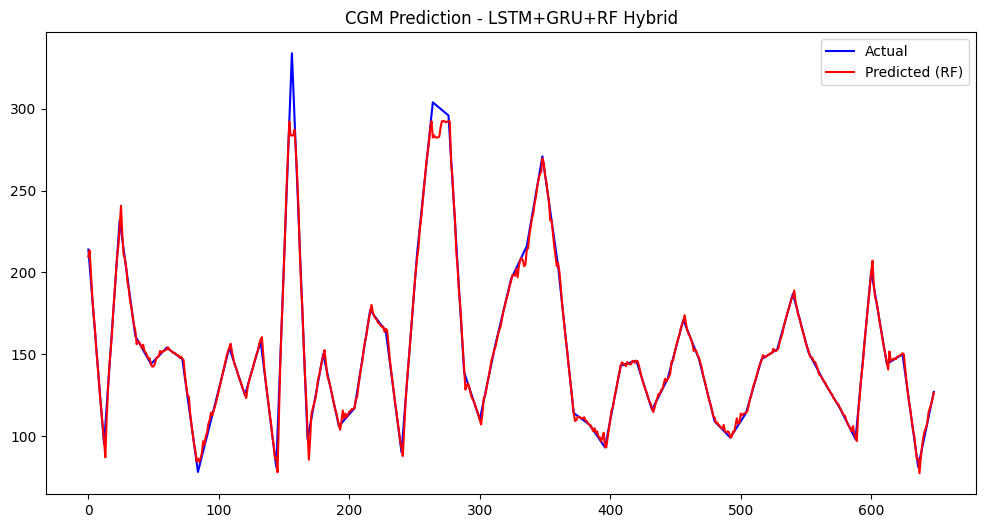

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 18_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-2500896112.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4405.000000
mean      131.607264
std        26.247933
min        57.000000
25%       114.333333
50%       128.583333
75%       146.000000
max       272.000000
Name: CGM, dtype: float64
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Linear Regression Meta Results: RMSE=1.7536, R²=0.9950

📊 Random Forest Meta Results: RMSE=1.8433, R²=0.9945


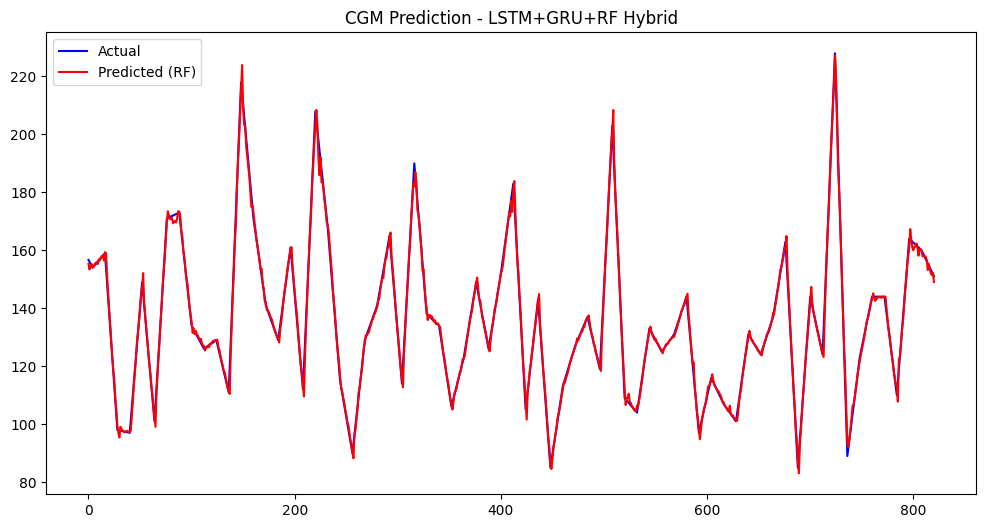

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 19_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-3256491488.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4441.000000
mean      131.705584
std        26.637560
min        52.000000
25%       114.333333
50%       128.333333
75%       145.666667
max       275.000000
Name: CGM, dtype: float64
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

📊 Linear Regression Meta Results: RMSE=1.8193, R²=0.9951

📊 Random Forest Meta Results: RMSE=2.1507, R²=0.9931


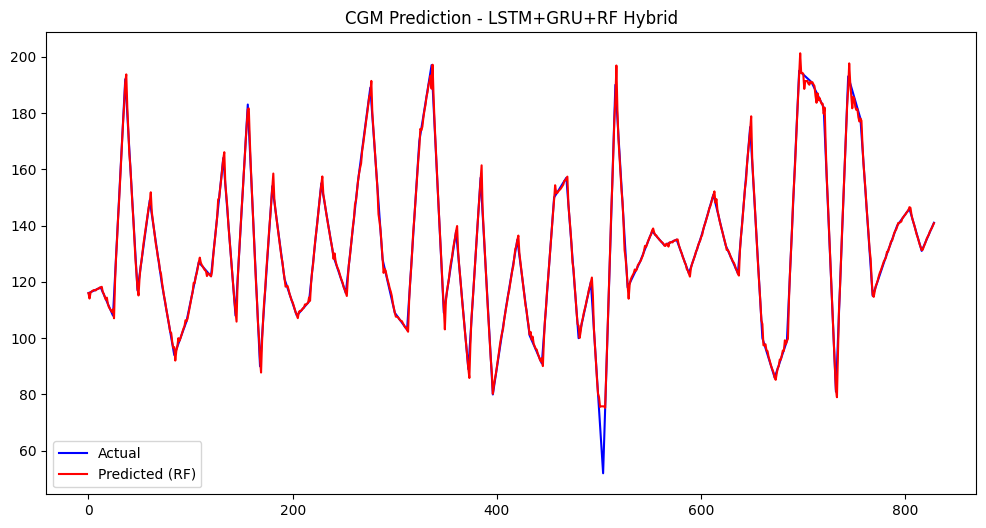

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 20_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

/tmp/ipython-input-2655179934.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.resample('15min').interpolate()
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



✅ CGM Summary:
count    4501.000000
mean      154.964119
std        45.902888
min        54.000000
25%       121.416667
50%       145.500000
75%       179.250000
max       376.000000
Name: CGM, dtype: float64
111/111 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

📊 Linear Regression Meta Results: RMSE=2.4486, R²=0.9978

📊 Random Forest Meta Results: RMSE=2.5746, R²=0.9976


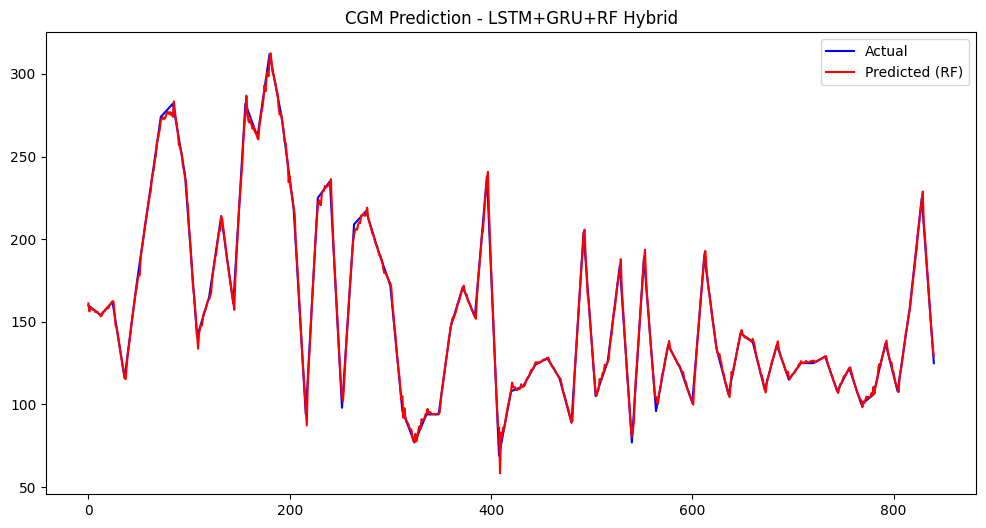

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 21_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 22_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 23_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 24_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()

In [ ]:
!pip install xgboost --quiet

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# ======================================
# Load & Prepare Data
# ======================================
df = pd.read_csv("/content/drive/MyDrive/diabetes/Subject 25_3hr.csv")
cgm_col = [c for c in df.columns if 'cgm' in c.lower()][0]

# If time column exists
if 'EventDateTime' in df.columns:
    df['EventDateTime'] = pd.to_datetime(df['EventDateTime'])
    df = df.set_index('EventDateTime').sort_index()
    df = df.resample('15min').interpolate()

cgm = df[cgm_col].dropna().values.reshape(-1, 1)

print("\n✅ CGM Summary:")
print(df[cgm_col].describe())

# ======================================
# Split + Scale
# ======================================
train_size = int(len(cgm) * 0.8)
train, test = cgm[:train_size], cgm[train_size:]

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# ======================================
# Create Sequences
# ======================================
def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback])
    return np.array(X), np.array(y)

lookback = 60
X_train, y_train = create_sequences(train_scaled, lookback)
X_test, y_test = create_sequences(test_scaled, lookback)

# ======================================
# LSTM Model
# ======================================
lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    LSTM(64),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
          validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

lstm_train = lstm.predict(X_train)
lstm_test = lstm.predict(X_test)

# ======================================
# GRU Model
# ======================================
gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.3),
    GRU(64),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=40, batch_size=16, verbose=0,
         validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

gru_train = gru.predict(X_train)
gru_test = gru.predict(X_test)

# ======================================
# Meta Learners
# ======================================
X_train_meta = np.hstack([lstm_train, gru_train])
X_test_meta = np.hstack([lstm_test, gru_test])

meta_lr = LinearRegression().fit(X_train_meta, y_train)
meta_rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train_meta, y_train.ravel())

pred_lr = scaler.inverse_transform(meta_lr.predict(X_test_meta).reshape(-1,1))
pred_rf = scaler.inverse_transform(meta_rf.predict(X_test_meta).reshape(-1,1))
y_true = scaler.inverse_transform(y_test.reshape(-1,1))

# ======================================
# Evaluate
# ======================================
for name, pred in zip(["Linear Regression", "Random Forest"], [pred_lr, pred_rf]):
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    r2 = r2_score(y_true, pred)
    print(f"\n📊 {name} Meta Results: RMSE={rmse:.4f}, R²={r2:.4f}")

plt.figure(figsize=(12,6))
plt.plot(y_true, label="Actual", color='blue')
plt.plot(pred_rf, label="Predicted (RF)", color='red')
plt.title("CGM Prediction - LSTM+GRU+RF Hybrid")
plt.legend()
plt.show()